### Approximate SyncRank with sparsified Laplacian 


<ul>
    <li>
        <a href="#MUNgraph"> 1. MUN graph</a>
    </li>
    <li>
        <a href="#EROgraph"> 2. ERO graph</a>
    </li>
</ul>

In [36]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase
using PlotlyJS
using JLD2

function sync_random_graphs(rng,type,n,p,q,eta,n_rep_sync,n_rep_cycle,n_batch,splg_methods)
    # planted ranking score
    planted_score = randperm(rng,n)

    # graph model
    if type=="MUN"
        meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
    elseif type=="ERO"
        meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
    end

    # storing settings
    D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep_sync)
    D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep_sync, rng; splg_methods)

    name = type*"_sync_"*"p"*string(p)*"_"*"eta"*string(eta)*"_"*"q"*string(q)
    file_sync = "figures/data/"*name*"_data.jld2"
    save(file_sync, "D_results", D_results,"D_params", D_params)
    println("synchronization results saved in "*file_sync)


    # computing the distribution of cycles
    nb_cycles = zeros(n_rep_cycle)
    weights_crsf = zeros(n_rep_cycle)
    for i_sample in 1:n_rep_cycle
        mtsf = multi_type_spanning_forest(rng, meta_g, q)
        # check nb roots and cycles
        cycles = get_prop(mtsf, :cycle_nodes)
        nb_cycles[i_sample] = length(cycles)
        weights_crsf[i_sample] = get_prop(mtsf, :weight)
    end    
    D_params = Dict("n_rep" => n_rep_cycle)
    name = type*"_cycles_"*"p"*string(p)*"_"*"eta"*string(eta)*"_"*"q"*string(q)
    file_cycles = "figures/data/"*name*"_data.jld2"
    save(file_cycles, "nb_cycles", nb_cycles,"weights_crsf", weights_crsf)
    println("synchronization results saved in "*file_sync)
    
    return file_sync, file_cycles
end

sync_random_graphs (generic function with 1 method)

In [21]:
rng = Random.default_rng()
splg_methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    "ST JL-LS",
    # "ST LS",
]
# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep_sync = 3 # number of runs
n_rep_cycle = 10
# regularization parameter
q = 0
# graph parameters
n = 2000;
p = 0.01;

### 1. MUN graph  <a id="MUNgraph"></a>

In [25]:
# graph parameters
type = "MUN" 
eta = 1e-1
# eta = 1e-3
file_sync, file_cycles = sync_random_graphs(rng,type,n,p,q,eta,n_rep_sync,n_rep_cycle,n_batch,splg_methods)

least eigval of Laplacian= 0.0023599937445958493
k = 

397 vs nb edges= 19889
 
k = 

397 vs nb edges= 19889
 
method: DPP(K) unif


method: DPP(K) JL-LS
method: 

iid JL-LS


method: ST JL-LS
synchronization results saved in figures/data/MUN_sync_p0.01_eta0.1_q0_data.jld2


synchronization results saved in figures/data/MUN_sync_p0.01_eta0.1_q0_data.jld2

("figures/data/MUN_sync_p0.01_eta0.1_q0_data.jld2", "figures/data/MUN_cycles_p0.01_eta0.1_q0_data.jld2")

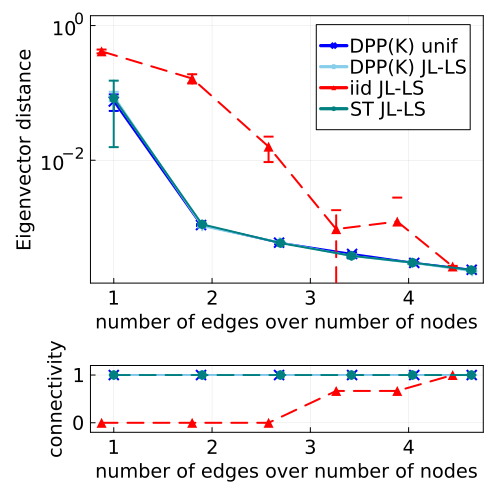

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/syncrank_err_MUNn2000p0.01eta0.1q0.pdf"

In [37]:
file_sync = "figures/data/MUN_sync_p0.01_eta0.1_q0_data.jld2"
type = "MUN" 
eta = 1e-1
q = 0
p = 0.01

D = load(file_sync)
D_results = D["D_results"]
# plotting distance between eigenvectors
check_connected = true
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

#### 1.1 Eigenvector estimation  <a id="MUNeig"></a>

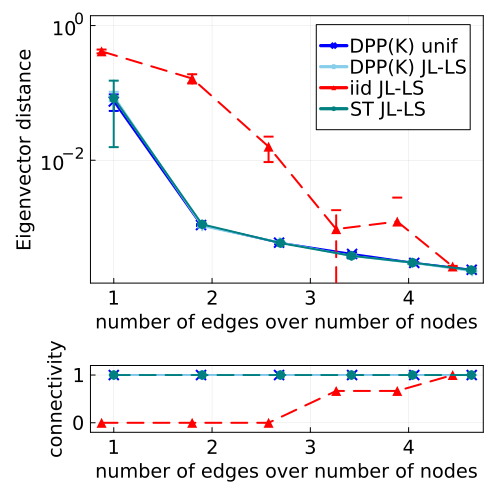

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/syncrank_err_MUNn2000p0.01eta0.1q0.pdf"

In [27]:
# plotting distance between eigenvectors
check_connected = true
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

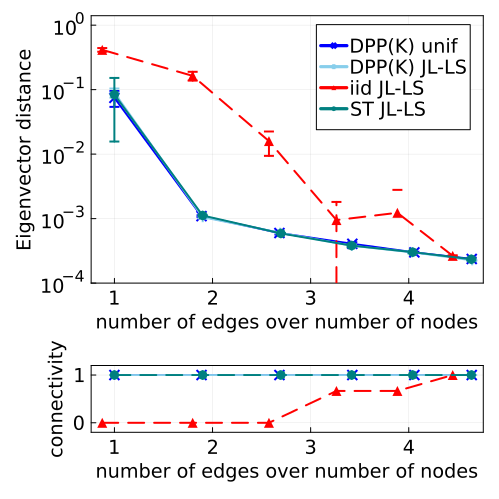

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


"syncrank_err_MUNn2000p0.01eta0.1q0"

In [38]:
# plotting distance between eigenvectors
check_connected = true
metric= "err"
y_limits = (1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

#### 1.2 Kendall's tau  <a id="MUNtau"></a>

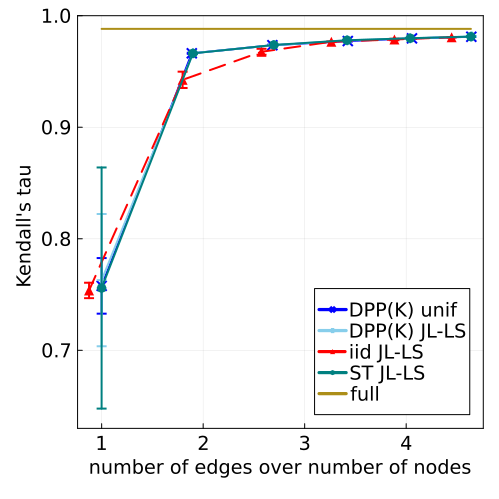

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/mfanuel/.julia/packages/Plots/sxUvK/src/axes.jl:76


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/syncrank_tau_MUNn2000p0.01eta0.1q0.pdf"

In [42]:
# plotting Kendall's tau between rankings
metric= "tau" 
y_limits = (0.63, 1.)
legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
Plots.savefig("figures/"*name*".pdf")

#### 1.3 Cycles  <a id="MUNcycles"></a>

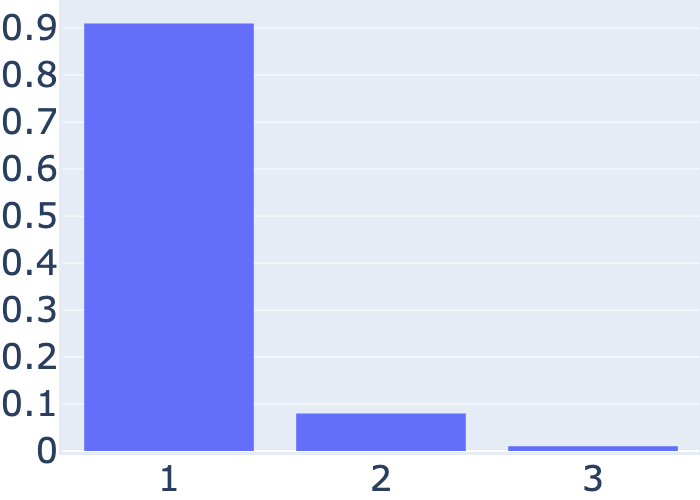

In [7]:
file_cycles = "figures/data/MUN_cycles_p0.01_eta0.1_q0_data.jld2"
eta = 0.1
q = 0
type = "MUN" 
D = load(file_cycles)

nb_cycles = D["nb_cycles"]
weights_crsf = D["weights_crsf"]

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "nb_cycles"*type*"eta"*string(eta)*"q"*string(q)
plt_cycles = PlotlyJS.plot(trace,layout)

# PlotlyJS.savefig(plt_cycles,"figures/"*name*".pdf")

In [19]:
trace = box(y=weights_crsf,
#boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=1),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=30,
    yaxis_range=[1, 1.02],
)
name = "crsf_weight"*type*"eta"*string(eta)*"q"*string(q)
plt_weight = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(plt_weight,"figures/"*name*".pdf")

"figures/crsf_weightMUNeta0.1q0.pdf"

### 2. ERO graph  <a id="EROgraph"></a>

In [32]:
type = "ERO" 

eta = 0.1
# planted ranking score
planted_score = randperm(rng,n)

file_sync, file_cycles = sync_random_graphs(rng,type,n,p,q,eta,n_rep_sync,n_rep_cycle,n_batch,splg_methods)

least eigval of Laplacian= 0.0856925106048638
k = 

398 vs nb edges= 19986
 
k = 

398 vs nb edges= 19986
 
method: DPP(K) unif


method: DPP(K) JL-LS
method: 

iid JL-LS


method: ST JL-LS
synchronization results saved in figures/data/ERO_sync_p0.01_eta0.1_q0_data.jld2


synchronization results saved in figures/data/ERO_sync_p0.01_eta0.1_q0_data.jld2

("figures/data/ERO_sync_p0.01_eta0.1_q0_data.jld2", "figures/data/ERO_cycles_p0.01_eta0.1_q0_data.jld2")

#### 2.1 Eigenvector estimation  <a id="EROeig"></a>

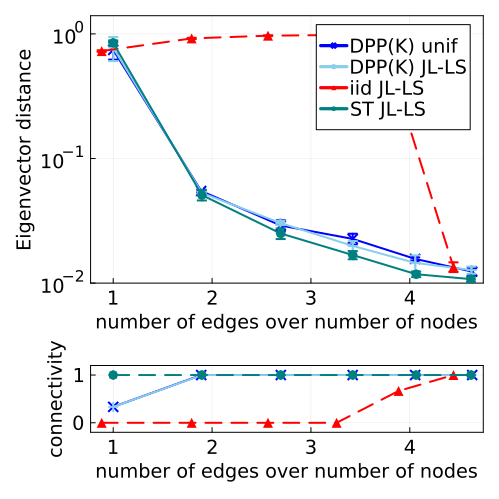

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/syncrank_err_EROn2000p0.01eta0.1q0.pdf"

In [28]:
file_sync = "figures/data/ERO_sync_p0.01_eta0.1_q0_data.jld2"
file_cycles = "figures/data/ERO_cycles_p0.01_eta0.1_q0_data.jld2"
eta = 0.1
q = 0
p = 0.01
type = "ERO"

D = load(file_sync)
D_results = D["D_results"]

check_connected = true
# plotting distance between eigenvectors
metric= "err"
y_limits = (1e-2, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods,check_connected)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
Plots.savefig("figures/"*name*".pdf")

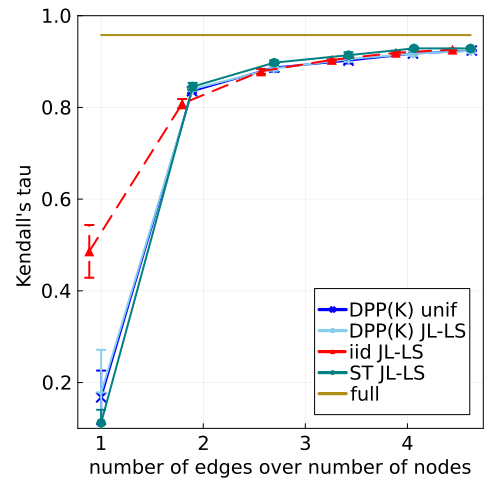

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/mfanuel/.julia/packages/Plots/sxUvK/src/axes.jl:76


"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/syncrank_tau_EROn2000p0.01eta0.1q0.pdf"

In [34]:
# plotting Kendall's tau between rankings
metric= "tau" 
y_limits = (0.1, 1.)
legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,splg_methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
# saving plot
Plots.savefig("figures/"*name*".pdf")

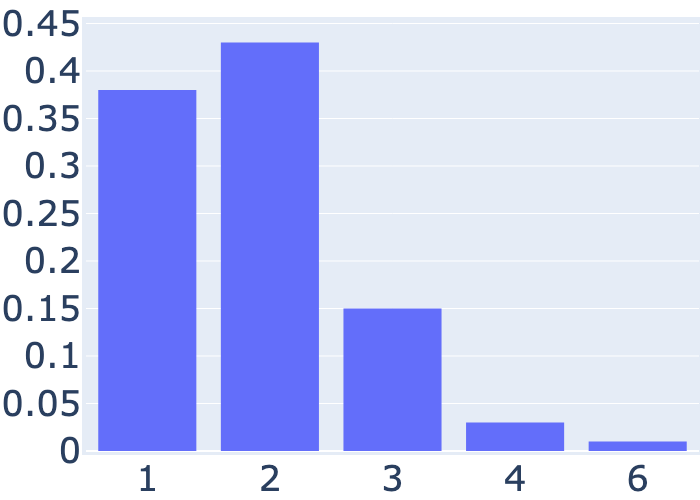

In [31]:
D = load(file_cycles)
nb_cycles = D["nb_cycles"]
weights_crsf = D["weights_crsf"]

cat_nb_cycles = string.(sort(Int.(nb_cycles)))
trace = PlotlyJS.histogram(x=cat_nb_cycles, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "nb_cycles"*type*"eta"*string(eta)*"q"*string(q)

plt_cycles = PlotlyJS.plot(trace,layout)
# PlotlyJS.savefig(plt_cycles,"figures/"*name*".pdf")

In [35]:
trace = box(y=weights_crsf,
marker=attr(
        color="LightSkyBlue",
        size=1),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=30,
    yaxis_range=[1, 4],

)

name = "crsf_weight"*type*"eta"*string(eta)*"q"*string(q)
plt_weight = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(plt_weight,"figures/"*name*".pdf")

"figures/crsf_weightEROeta0.1q0.pdf"